# Import/Definitions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scintools.ththmod as THTH
from matplotlib.colors import LogNorm
import astropy.units as u
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit

In [2]:
##Function for making extent tuple for plotting
def ext_find(x,y):
    dx=np.diff(x).mean()
    dy=np.diff(y).mean()
    ext=[(x[0]-dx/2).value,(x[-1]+dx/2).value,(y[0]-dy/2).value,(y[-1]+dy/2).value]
    return(ext)

##Curvature evolution with freuquency
def eta_func(f0,A):
    return(A/(f0**2))

# Load and Visualize Data

Text(0.5, 1.0, 'Secondary Spectrum')

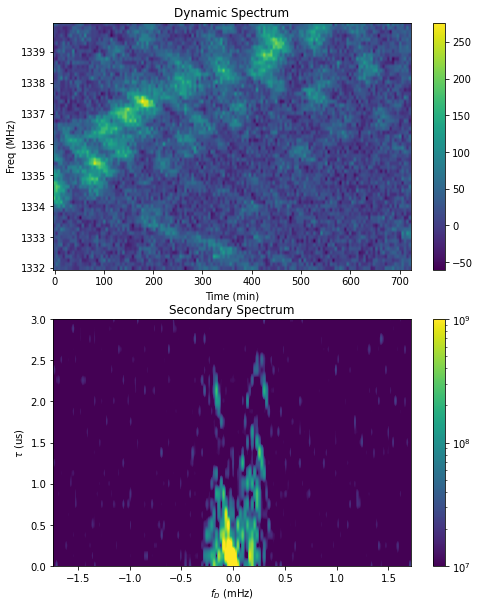

In [3]:
##Load Sample Data
arch=np.load('Sample_Data.npz')
time=arch['t_s']*u.s
freq=arch['f_MHz']*u.MHz
##Define Wavefield
espec=arch['Espec']
##Create noisy dynamic spectrum
dspec=np.abs(espec)**2+np.random.normal(0,20,espec.shape)

## Define coordinates for conjugate/secondary spectra
fd=THTH.fft_axis(time,u.mHz)
tau=THTH.fft_axis(freq[:64],u.us)

##Sample spectra from portion of data
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.imshow(dspec[:64,:],origin='lower',aspect='auto',extent=ext_find(time.to(u.min),freq[:64]))
SS=np.fft.fftshift(np.abs(np.fft.fft2(dspec[:64,:]))**2)
plt.xlabel('Time (min)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum')
plt.colorbar()
plt.subplot(212)
plt.imshow(SS,norm=LogNorm(),origin='lower',aspect='auto',extent=ext_find(fd,tau),vmax=1e9,vmin=1e7)
plt.ylim((0,3))
plt.colorbar()
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Secondary Spectrum')


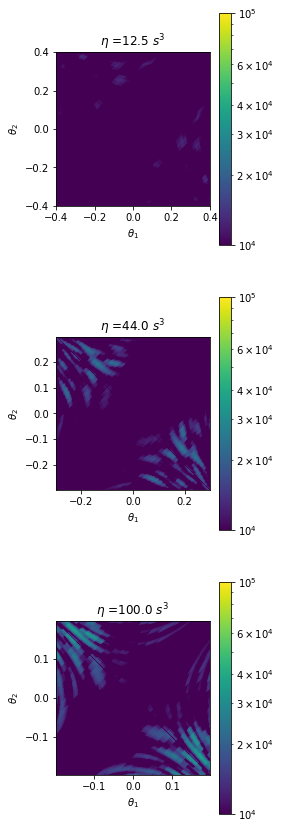

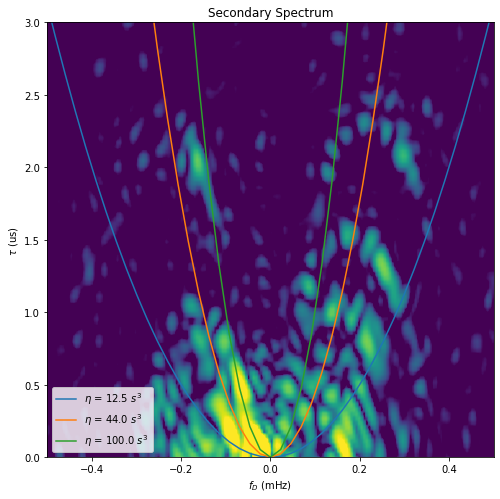

In [4]:
##Sample thth plots for a small portion of data
dspec2=dspec[:64]
freq2=freq[:64]

##Pad before forming secondary spectrum
npad=3
dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

##Form SS and coordinate arrays
SS=np.fft.fftshift(np.fft.fft2(dspec_pad))

## Define coordinates for conjugate/secondary spectra
fd=THTH.fft_axis(time,u.mHz,npad)
tau=THTH.fft_axis(freq[:64],u.us,npad)

##Example curvatures
etas=np.array([12.5,44,100])*u.us/u.mHz**2

plt.figure(figsize=(4,12))
##Bin Edges for thth plot 
##(should be symmetric about 0 and contain an even number of points)
edges=np.linspace(-.4,.4,512)

##Create thth plot for each sample curvature
for i in range(etas.shape[0]):
    ##The redmap fuction automatically crops the array to stay within the SS
    thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, etas[i], edges)
    plt.subplot(3,1,i+1)
    plt.imshow(np.abs(thth_red),
               norm=LogNorm(),
               extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
               origin='lower',vmin=1e4,vmax=1e5)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'$\eta$ =%s $s^3$' %etas[i].to_value(u.s**3))
    plt.colorbar()
plt.tight_layout()

##Show secondary spectrum and sample curvatures
plt.figure(figsize=(8,8))
plt.imshow(np.abs(SS)**2,norm=LogNorm(),origin='lower',aspect='auto',extent=ext_find(fd,tau),vmax=1e9,vmin=1e7)
plt.ylim((0,3))
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Secondary Spectrum')
for i in range(3):
    plt.plot(fd,etas[i]*fd**2,label=r'$\eta$ = %s $s^3$' %etas[i].to_value(u.s**3))
plt.xlim((-.5,.5))
plt.legend()

# Single Curvature Measurement

/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:147: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*e

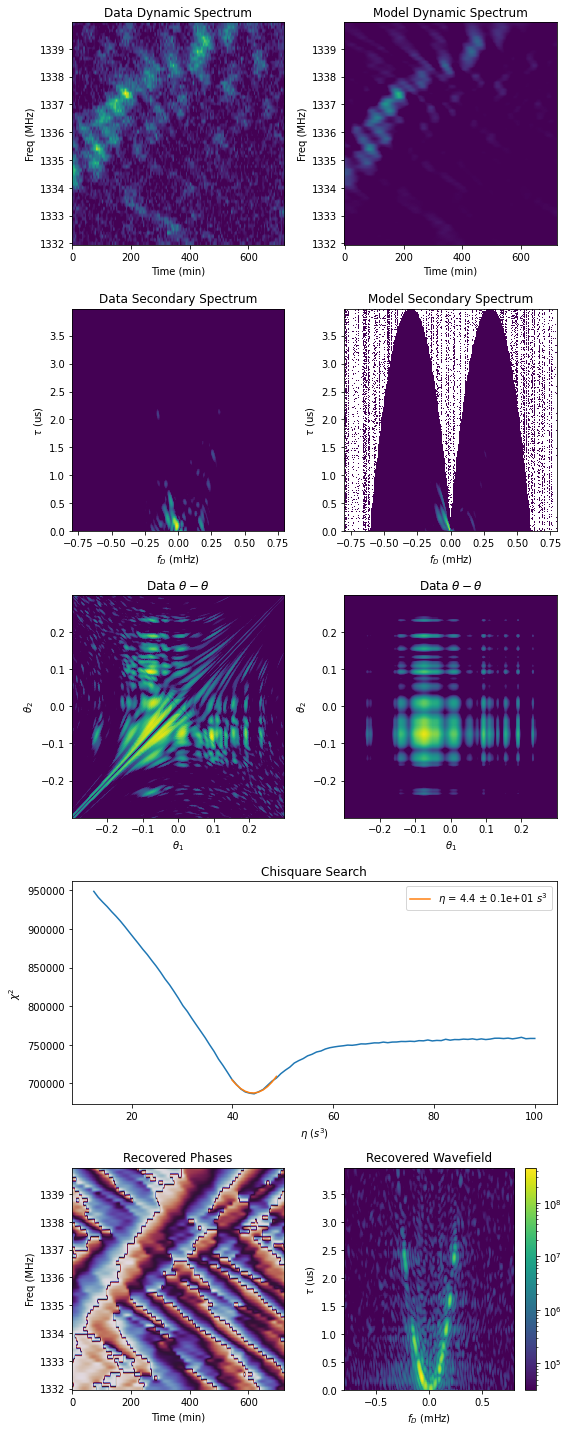

In [5]:
##Sample Curvature Search and Plots for Small Chunk of Data
dspec2=dspec[:64]
freq2=freq[:64]

##Pad before forming secondary spectrum
npad=3
dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

##Form SS and coordinate arrays
SS=np.fft.fft2(dspec_pad)
SS[0,0]=0
SS=np.fft.fftshift(SS)
fd=THTH.fft_axis(time,u.mHz,npad)
tau=THTH.fft_axis(freq2,u.us,npad)

##Define range of curvatures to search
eta_low=.5*u.us/(.04*u.mHz**2)
eta_high=4*u.us/(.04*u.mHz**2)


##Estimate noise in dynamic spectrum
temp=np.fft.fftshift(np.abs(np.fft.fft2(dspec)/np.sqrt(dspec.shape[0]*dspec.shape[1]))**2)
N=np.sqrt(temp[:temp.shape[0]//6,:temp.shape[1]//6].mean())

##Setup for chisq search
etas=np.linspace(eta_low.value,eta_high.value,100)*eta_low.unit
chisq=np.zeros(etas.shape[0])

##Determine chisq for each curvature
mask=np.ones(dspec2.shape,dtype=bool)
for i in range(etas.shape[0]):
    eta=etas[i]
    ##Fits a model generated by taking the outer product of the dominate eigenvector
    ##(in theta-theta space) and then mapping back to the dynamic spectrum
    chisq[i]=THTH.chisq_calc(dspec2,SS, tau, fd, eta, edges,mask,N)

##Fit for a parabola around the minimum
e_min=etas[chisq==chisq.min()][0]
etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
chisq_fit=chisq[np.abs(etas-e_min)<.1*e_min]
C=chisq_fit.min()
x0=etas_fit[chisq_fit==C][0].value
A=(chisq_fit[0]-C)/((etas_fit[0].value-x0)**2)
popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,chisq_fit,p0=np.array([A,x0,C]))
eta_fit=popt[1]*etas.unit
eta_sig=np.sqrt((chisq_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit

##Diagnostic plots for fit
THTH.PlotFunc(dspec2,time,freq2,SS,fd,tau,
            edges,eta_fit,eta_sig,etas,chisq,etas_fit,popt,method='chisq')

# Full Curvature Analysis

## Looped Fitting

In [6]:
##Divide dynamic spectrum into small chunks in frequency 
##For some datasets you may need to divide into time chunks aswell 
nchunk=dspec.shape[0]//64

##Arrays for curvatures in each frequency chunk
f0=np.zeros(nchunk)*u.MHz
eta_evo=np.zeros(nchunk)*u.us/u.mHz**2
eta_evo_err=np.zeros(nchunk)*u.us/u.mHz**2

##Loop over chunks
for fc in range(nchunk):
    ##Define dspec and freq array for chunk
    dspec2=dspec[fc*64:(fc+1)*64]
    freq2=freq[fc*64:(fc+1)*64]
    f0[fc]=freq2.mean()
    
    ##Pad before forming dynamic spectrum
    npad=3
    dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

    ##Form SS and coordinate arrays
    SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
    fd=THTH.fft_axis(time,u.mHz,npad)
    tau=THTH.fft_axis(freq2,u.us,npad)

    ##Define range of curvatures to search
    eta_low=.5*u.us/(.04*u.mHz**2)
    eta_high=4*u.us/(.04*u.mHz**2)


    ##Estimate noise in dynamic spectrum
    temp=np.fft.fftshift(np.abs(np.fft.fft2(dspec)/np.sqrt(dspec.shape[0]*dspec.shape[1]))**2)
    N=np.sqrt(temp[:temp.shape[0]//6,:temp.shape[1]//6].mean())

    ##Setup for chisq search
    etas=np.linspace(eta_low.value,eta_high.value,100)*eta_low.unit
    chisq=np.zeros(etas.shape[0])
    ##Bin Edges for thth plot 
    ##(should be symmetric about 0 and contain an even number of points)
    edges=np.linspace(-.4,.4,512)
    ##Determine chisq for each curvature
    for i in range(etas.shape[0]):
        eta=etas[i]
        chisq[i]=THTH.chisq_calc(dspec2,SS, tau, fd, eta, edges,mask,N)

    ## Fit for curvature to minimize chisq
    e_min=etas[chisq==chisq.min()][0]
    etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
    chisq_fit=chisq[np.abs(etas-e_min)<.1*e_min]
    C=chisq_fit.min()
    x0=etas_fit[chisq_fit==C][0].value
    A=(chisq_fit[0]-C)/((etas_fit[0].value-x0)**2)
    popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,chisq_fit,p0=np.array([A,x0,C]))
    eta_fit=popt[1]*etas.unit
    eta_sig=np.sqrt((chisq_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit

    eta_evo[fc]=eta_fit
    eta_evo_err[fc]=eta_sig


/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:147: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*e

## Curvature Evolution

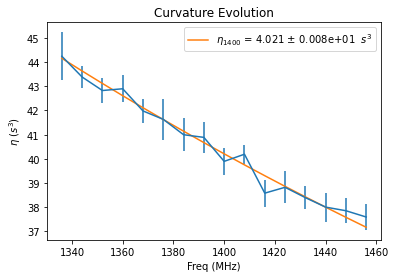

In [7]:
##Fit for overall curvature evolution
popt,pcov=curve_fit(eta_func,f0.value,eta_evo.value,sigma=eta_evo_err.value,p0=[np.median(eta_evo.value*f0.value)])
A=popt[0]*(u.us)*u.MHz**2/u.mHz**2
A_err=np.sqrt(pcov[0,0])*u.us*u.MHz**2/u.mHz**2
A/=(1400*u.MHz)**2
A_err/=(1400*u.MHz)**2

exp_fit=int(('%.0e' %A.value)[2:])
exp_err=int(('%.0e' %A_err.value)[2:])
fmt="{:.%se}" %(exp_fit-exp_err)
fit_string=fmt.format(A.value)[:2+exp_fit-exp_err]
err_string='0%s' %fmt.format(10**(exp_fit)+A_err.value)[1:]

plt.figure()
plt.errorbar(f0.value,eta_evo.value,yerr=eta_evo_err.value)
plt.plot(f0.value,eta_func(f0.value,*popt),label=r'$\eta_{1400}$ = %s $\pm$ %s  $s^3$' %(fit_string, err_string))
plt.title(r'Curvature Evolution')
plt.xlabel('Freq (MHz)')
plt.ylabel(r'$\eta$ ($s^3$)')
plt.legend()

# Phase Retrieval

## Retieve for overlapping chunks

In [8]:
## Chunk Widths in frequency and time:
cwf=64
cwt=dspec.shape[1]

##Half widths
hwf=cwf//2
hwt=cwt//2

##Number of chunks for the overlapping mosaic
##(each chunk overlaps 50% with adjacent chunks in time and freuency)
ncf=(dspec.shape[0]-hwf)//hwf
nct=(dspec.shape[1]-hwt)//hwt

##Array for storing chunks
chunks=np.zeros((ncf,nct,cwf,cwt),dtype=complex)

for cf in range(ncf):
    for ct in range(nct):
        ##Select Chunk and determine curvature
        dspec2=np.copy(dspec[cf*hwf:cf*hwf+cwf,ct*hwt:ct*hwt+cwt])
        dspec2-=dspec2.mean()
        freq2=freq[cf*hwf:cf*hwf+cwf]
        time2=time[ct*hwt:ct*hwt+cwt]
        eta=A*((1400*u.MHz/freq2.mean())**2)

        ##Pad
        dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

        SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
        fd=THTH.fft_axis(time2,u.mHz,npad)
        tau=THTH.fft_axis(freq2,u.us,npad)

        ##Create and decompose theta-theta
        thth_red,edges_red=THTH.thth_redmap(SS, tau, fd, eta, edges)
        w,V=eigsh(thth_red,1)
        w=w[0]
        V=V[:,0]

        ##Construct 1D theta-theta
        thth2_red=thth_red*0
        thth2_red[thth2_red.shape[0]//2,:]=np.conjugate(V)*np.sqrt(w)
        ##Map back to time/frequency space
        recov=THTH.rev_map(thth2_red,tau,fd,eta,edges_red,isdspec=False)
        model_E=np.fft.ifft2(np.fft.ifftshift(recov))[:dspec2.shape[0],:dspec2.shape[1]]
        model_E*=(dspec2.shape[0]*dspec2.shape[1]/4)
        model_E=model_E[:dspec2.shape[0],:dspec2.shape[1]]
        chunks[cf,ct,:,:]=model_E

/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:135: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).real)[0] +\
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: divide by zero encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:139: RuntimeWarning: invalid value encountered in true_divide
  weights=np.ravel(thth/np.sqrt(np.abs(2*eta*fd_map.T).value)).imag)[0]*1j
/home/daniel/.local/lib/python3.6/site-packages/scintools/ththmod.py:155: RuntimeWarning: invalid value encountered in true_divide
  recov/=norm


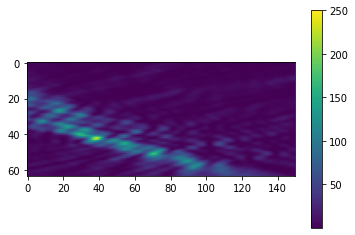

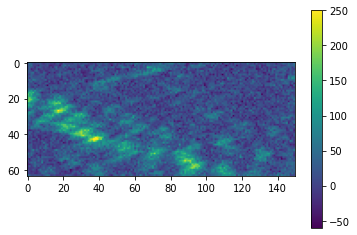

In [9]:
plt.figure()
plt.imshow(np.abs(chunks[0,0,:,:])**2,vmax=250)
plt.colorbar()
plt.figure()
plt.imshow(dspec[:chunks.shape[2],:chunks.shape[3]],vmax=250)
plt.colorbar()

## Rotate and combine chunks

2.062001265585416

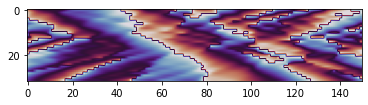

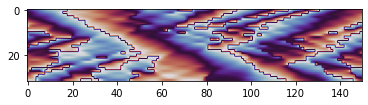

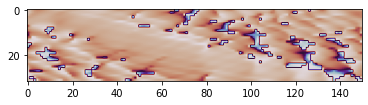

In [10]:
plt.figure()
plt.imshow(np.angle(chunks[0,0,32:,:]),cmap='twilight')
plt.figure()
plt.imshow(np.angle(chunks[1,0,:32,:]),cmap='twilight')
plt.figure()
plt.imshow(np.angle(chunks[0,0,32:,:]*np.conjugate(chunks[1,0,:32,:])),vmin=-np.pi,vmax=np.pi,cmap='twilight')
np.angle(chunks[0,0,32:,:]*np.conjugate(chunks[1,0,:32,:])).mean()

In [11]:
E_recov=THTH.mosaic(chunks)

    
dspec_ext=ext_find(time.to(u.hour),freq)
plt.figure(figsize=(8,16))
plt.subplot(222)
plt.imshow(np.abs(E_recov)**2,aspect='auto',origin='lower',vmin=0,vmax=250,extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum Model')
plt.subplot(221)
plt.imshow(np.abs(espec)**2,aspect='auto',origin='lower',vmin=0,vmax=250,extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Dynamic Spectrum')
plt.subplot(224)
plt.imshow(np.angle(E_recov),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase Model')
plt.subplot(223)
plt.imshow(np.angle(espec),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase')

AttributeError: module 'scintools.ththmod' has no attribute 'mosaic'

In [ ]:
plt.figure()
plt.imshow(np.angle(espec*np.conjugate(E_recov)),
           cmap='twilight',
           aspect='auto',
           origin='lower',
           extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Phase Difference')
plt.colorbar()
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.angle(E_recov*np.exp(1j*np.angle((espec*np.conjugate(E_recov)).mean()))),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Corrected Phase')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(espec),cmap='twilight',aspect='auto',origin='lower',extent=dspec_ext)
plt.xlabel('Time (hrs)')
plt.ylabel('Freq (MHz)')
plt.title('Wave Field Phase')
plt.colorbar()

In [ ]:
fd_full=np.fft.fftshift(np.fft.fftfreq(time.shape[0],time[1]-time[0]).to(u.mHz))*u.mHz
tau_full=np.fft.fftshift(np.fft.fftfreq(freq.shape[0],freq[1]-freq[0]).to(u.us))*u.us
SS_ext_full=ext_find(fd,tau)
temp2=np.nan_to_num(np.sqrt(dspec))*np.exp(1j*np.angle(E_recov))

plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(E_recov)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field Model')
plt.xlim((-1,1))
plt.ylim((-1,3))
plt.subplot(132)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(espec)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field')
plt.xlim((-1,1))
plt.ylim((-1,3))

plt.subplot(133)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(temp2)))**2,
           norm=LogNorm(),
           origin='lower',
           aspect='auto',
           extent=SS_ext_full,
           vmax=1e10,
           vmin=1e2)
plt.xlabel(r'$f_D$ (mHz)')
plt.ylabel(r'$\tau$ (us)')
plt.title('Wave Field Model (Forced Amplitudes)')
plt.xlim((-1,1))
plt.ylim((-1,3))

# Eigenvalue Search (Development)

The Eigenvalue Curvature Search (TECS) is implemented very similarly to the reduced $\chi^2$ fitting above. The main difference is that instead of mapping back to the dynamic spectrum, we look at the largest eigenvalue of the $\theta-\theta$ matrix. This has several advantages: 
\begin{enumerate}
  \item Fewer transformations lead to a faster run time
  \item No need to worry about resolution in the reversemap (fewer dials)
\end{enumerate}

The only user side changes are that the dynamic spectrum should have its mean subtracted, and the largest eigenvalue at each frequency is given by the function Eval_calc(SS, tau, fd, eta, edges) in the ththmod.py

## Single Chunk

In [ ]:
##Sample Curvature Search and Plots for Small Chunk of Data
dspec2=dspec[:64]-dspec[:64].mean()
freq2=freq[:64]

##Pad before forming secondary spectrum
npad=3
dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

##Form SS and coordinate arrays
SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
fd=THTH.fft_axis(time,u.mHz,npad)
tau=THTH.fft_axis(freq2,u.us,npad)

##Define range of curvatures to search
eta_low=.5*u.us/(.04*u.mHz**2)
eta_high=4*u.us/(.04*u.mHz**2)


##Setup for chisq search
etas=np.linspace(eta_low.value,eta_high.value,100)*eta_low.unit
eigs=np.zeros(etas.shape[0])

##Determine chisq for each curvature
mask=np.ones(dspec2.shape,dtype=bool)
for i in range(etas.shape[0]):
    eta=etas[i]
    ##Fits a model generated by taking the outer product of the dominate eigenvector
    ##(in theta-theta space) and then mapping back to the dynamic spectrum
    eigs[i]=THTH.Eval_calc(SS, tau, fd, eta, edges)

##Fit for a parabola around the minimum
e_min=etas[eigs==eigs.max()][0]
etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
eigs_fit=eigs[np.abs(etas-e_min)<.1*e_min]
C=eigs_fit.max()
x0=etas_fit[eigs_fit==C][0].value
A=(eigs_fit[0]-C)/((etas_fit[0].value-x0)**2)
popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,eigs_fit,p0=np.array([A,x0,C]))
eta_fit=popt[1]*etas.unit
eta_sig=np.sqrt(-(eigs_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit

THTH.PlotFunc(dspec2,time,freq2,SS,fd,tau,
            edges,eta_fit,eta_sig,etas,eigs,etas_fit,popt)

## Full Curvature Analysis

### Looped Fitting

In [ ]:
##Divide dynamic spectrum into small chunks in frequency 
##For some datasets you may need to divide into time chunks aswell 
nchunk=dspec.shape[0]//64

##Arrays for curvatures in each frequency chunk
f0=np.zeros(nchunk)*u.MHz
eta_evo=np.zeros(nchunk)*u.us/u.mHz**2
eta_evo_err=np.zeros(nchunk)*u.us/u.mHz**2

##Loop over chunks
for fc in range(nchunk):
    ##Define dspec and freq array for chunk
    dspec2=dspec[fc*64:(fc+1)*64]
    dspec2-=dspec2.mean()
    freq2=freq[fc*64:(fc+1)*64]
    f0[fc]=freq2.mean()
    
    ##Pad before forming dynamic spectrum
    npad=3
    dspec_pad=np.pad(dspec2,((0,npad*dspec2.shape[0]),(0,npad*dspec2.shape[1])),mode='constant',constant_values=dspec2.mean())

    ##Form SS and coordinate arrays
    SS=np.fft.fftshift(np.fft.fft2(dspec_pad))
    fd=THTH.fft_axis(time,u.mHz,npad)
    tau=THTH.fft_axis(freq2,u.us,npad)

    ##Define range of curvatures to search
    eta_low=30*u.us/u.mHz**2
    eta_high=50*u.us/u.mHz**2

    ##Setup for chisq search
    etas=np.linspace(eta_low.value,eta_high.value,25)*eta_low.unit
    evals=np.zeros(etas.shape[0])
    ##Bin Edges for thth plot 
    ##(should be symmetric about 0 and contain an even number of points)
    edges=np.linspace(-.4,.4,512)
    ##Determine chisq for each curvature
    for i in range(etas.shape[0]):
        eta=etas[i]
        evals[i]=THTH.Eval_calc(SS, tau, fd, eta, edges)

    e_min=etas[evals==evals.max()][0]
    etas_fit=etas[np.abs(etas-e_min)<.1*e_min]
    evals_fit=evals[np.abs(etas-e_min)<.1*e_min]
    C=evals_fit.max()
    x0=etas_fit[evals_fit==C][0].value
    A=(evals_fit[0]-C)/((etas_fit[0].value-x0)**2)
    popt,pcov=curve_fit(THTH.chi_par,etas_fit.value,evals_fit,p0=np.array([A,x0,C]))
    eta_fit=popt[1]*etas.unit
    eta_sig=np.sqrt(-(evals_fit-THTH.chi_par(etas_fit.value,*popt)).std()/popt[0])*etas.unit

    eta_evo[fc]=eta_fit
    eta_evo_err[fc]=eta_sig


In [ ]:
##Fit for overall curvature evolution
popt,pcov=curve_fit(eta_func,f0.value,eta_evo.value,sigma=eta_evo_err.value,p0=[np.median(eta_evo.value*f0.value)])
A=popt[0]*(u.us)*u.MHz**2/u.mHz**2
A_err=np.sqrt(pcov[0,0])*u.us*u.MHz**2/u.mHz**2
A/=(1400*u.MHz)**2
A_err/=(1400*u.MHz)**2

exp_fit=int(('%.0e' %A.value)[2:])
exp_err=int(('%.0e' %A_err.value)[2:])
fmt="{:.%se}" %(exp_fit-exp_err)
fit_string=fmt.format(A.value)[:2+exp_fit-exp_err]
err_string='0%s' %fmt.format(10**(exp_fit)+A_err.value)[1:]

plt.figure()
plt.errorbar(f0.value,eta_evo.value,yerr=eta_evo_err.value)
plt.plot(f0.value,eta_func(f0.value,*popt),label=r'$\eta_{1400}$ = %s $\pm$ %s  $s^3$' %(fit_string, err_string))
plt.title(r'Curvature Evolution')
plt.xlabel('Freq (MHz)')
plt.ylabel(r'$\eta$ ($s^3$)')
plt.legend()

In [ ]:
temp1=np.copy(espec[:64,:])
wf=np.fft.fftshift(np.fft.fft2(temp1))
wf[1:,1:]=wf[1:,1:][::-1,::-1]
wf=np.conjugate(wf)
temp2=np.fft.ifft2(np.fft.ifftshift(wf))
plt.figure()
plt.subplot(211)
plt.imshow(-np.angle(temp1),cmap='twilight')
plt.subplot(212)
plt.imshow(np.angle(temp2),cmap='twilight')